In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 622ms/step - loss: 0.1316
Average validation loss: 0.6591622233390808
4/4 [==============================] - 6s 638ms/step - loss: 0.1316 - val_loss: 0.6592
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 598ms/step - loss: 0.1029 - val_loss: 0.6592
Average validation loss: 0.29576802253723145
4/4 [==============================] - 9s 612ms/step - loss: 0.1029 - val_loss: 0.4775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 596ms/step - loss: 0.0799 - val_loss: 0.4775
Average validation loss: 0.29179802536964417
4/4 [==============================] - 11s 608ms/step - loss: 0.0799 - val_loss: 0.4156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 797ms/step - loss: 0.0102
Average validation loss: 8.526512287020116e-13
8/8 [==============================] - 6s 808ms/step - loss: 0.0102 - val_loss: 8.5265e-13
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 813ms/step - loss: 0.0100 - val_loss: 8.5265e-13
Average validation loss: 0.0022492550779134035
8/8 [==============================] - 13s 826ms/step - loss: 0.0100 - val_loss: 0.0011    
Epoch 3/10
8/8 [==============================] - 19s 784ms/step - loss: 0.0097 - val_loss: 0.0011
Average validation loss: 0.0004608777235262096
8/8 [==============================] - 20s 800ms/step - loss: 0.0097 - val_loss: 9.0338e-04
Epoch 4/10
8/8 [==============================] - 26s 780ms/step - loss: 0.0094 - val_loss: 9.0338e-04
Average validation loss: 3.960452517048907e-07
8/8 [===================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 804ms/step - loss: 0.0103
Average validation loss: 0.03734830869022213
12/12 [==============================] - 10s 821ms/step - loss: 0.0103 - val_loss: 0.0373
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 799ms/step - loss: 0.0105 - val_loss: 0.0373
Average validation loss: 0.048274958433466963
12/12 [==============================] - 20s 810ms/step - loss: 0.0105 - val_loss: 0.0428
Epoch 3/10
12/12 [==============================] - 29s 789ms/step - loss: 0.0104 - val_loss: 0.0428
Average validation loss: 0.09914169608265173
12/12 [==============================] - 29s 801ms/step - loss: 0.0104 - val_loss: 0.0616
Epoch 4/10
12/12 [==============================] - 39s 784ms/step - loss: 0.0102 - val_loss: 0.0616
Average validation loss: 0.06348360217301281
12/12 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 726ms/step - loss: 0.0071
Average validation loss: 0.05752886397314683
16/16 [==============================] - 12s 738ms/step - loss: 0.0071 - val_loss: 0.0575
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 716ms/step - loss: 0.0075 - val_loss: 0.0575
Average validation loss: 0.048493524217349204
16/16 [==============================] - 24s 729ms/step - loss: 0.0075 - val_loss: 0.0530
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 719ms/step - loss: 0.0075 - val_loss: 0.0530
Average validation loss: 0.0533109379644543
16/16 [==============================] - 35s 732ms/step - loss: 0.0075 - val_loss: 0.0531
Epoch 4/10
16/16 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 726ms/step - loss: 0.0053
Average validation loss: 0.020507060061208903
20/20 [==============================] - 15s 740ms/step - loss: 0.0053 - val_loss: 0.0205
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 731ms/step - loss: 0.0050 - val_loss: 0.0205
Average validation loss: 0.016445536364335565
20/20 [==============================] - 30s 744ms/step - loss: 0.0050 - val_loss: 0.0185
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 722ms/step - loss: 0.0046 - val_loss: 0.0185
Average validation loss: 0.01692943958332762
20/20 [==============================] - 44s 734ms/step - loss: 0.0046 - val_loss: 0.0180
Epoch 4/10
20/20 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 750ms/step - loss: 0.0058
Average validation loss: 0.01674836144472162
24/24 [==============================] - 18s 761ms/step - loss: 0.0058 - val_loss: 0.0167
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 36s 731ms/step - loss: 0.0051 - val_loss: 0.0167
Average validation loss: 0.1735415980219841
24/24 [==============================] - 36s 744ms/step - loss: 0.0051 - val_loss: 0.0951
Epoch 3/10
24/24 [==============================] - 54s 720ms/step - loss: 0.0046 - val_loss: 0.0951
Average validation loss: 0.028531505493447185
24/24 [==============================] - 54s 733ms/step - loss: 0.0046 - val_loss: 0.0729
Epoch 4/10
24/24 [==============================] - 71s 713ms/step - loss: 0.0043 - val_loss: 0.0729
Average validation loss: 0.03620932095994552
24/24 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 733ms/step - loss: 0.0083
Average validation loss: 0.05110701844096184
40/40 [==============================] - 30s 745ms/step - loss: 0.0083 - val_loss: 0.0511
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 725ms/step - loss: 0.0076 - val_loss: 0.0511
Average validation loss: 0.08346648700535297
40/40 [==============================] - 59s 736ms/step - loss: 0.0076 - val_loss: 0.0673
Epoch 3/10
40/40 [==============================] - 89s 745ms/step - loss: 0.0074 - val_loss: 0.0673
Average validation loss: 0.09409651570022107
40/40 [==============================] - 89s 757ms/step - loss: 0.0074 - val_loss: 0.0762
Epoch 4/10
40/40 [==============================] - 119s 737ms/step - loss: 0.0070 - val_loss: 0.0762
Average validation loss: 0.03015286345034838
40/40 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 0.0056
Average validation loss: 0.009749872588895295
48/48 [==============================] - 35s 735ms/step - loss: 0.0056 - val_loss: 0.0097
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 726ms/step - loss: 0.0046 - val_loss: 0.0097
Average validation loss: 0.01004444072023151
48/48 [==============================] - 71s 739ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 3/10
48/48 [==============================] - 106s 731ms/step - loss: 0.0043 - val_loss: 0.0099
Average validation loss: 0.011322370725098748
48/48 [==============================] - 107s 743ms/step - loss: 0.0043 - val_loss: 0.0104
Epoch 4/10
48/48 [==============================] - 141s 722ms/step - loss: 0.0042 - val_loss: 0.0104
Average validation loss: 0.012858114271615512
48/48 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 731ms/step - loss: 0.0060
Average validation loss: 0.013174966512475997
56/56 [==============================] - 42s 742ms/step - loss: 0.0060 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 720ms/step - loss: 0.0052 - val_loss: 0.0132
Average validation loss: 0.013984574339693452
56/56 [==============================] - 83s 732ms/step - loss: 0.0052 - val_loss: 0.0136
Epoch 3/10
56/56 [==============================] - 123s 725ms/step - loss: 0.0046 - val_loss: 0.0136
Average validation loss: 0.01528625486309841
56/56 [==============================] - 124s 737ms/step - loss: 0.0046 - val_loss: 0.0141
Epoch 4/10
56/56 [==============================] - 164s 720ms/step - loss: 0.0045 - val_loss: 0.0141
Average validation loss: 0.04190978223877741
56/56 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 721ms/step - loss: 0.0049
Average validation loss: 0.01139945856994018
64/64 [==============================] - 47s 733ms/step - loss: 0.0049 - val_loss: 0.0114
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 718ms/step - loss: 0.0039 - val_loss: 0.0114
Average validation loss: 0.009249797878311483
64/64 [==============================] - 94s 730ms/step - loss: 0.0039 - val_loss: 0.0103
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 719ms/step - loss: 0.0034 - val_loss: 0.0103
Average validation loss: 0.00975762500289043
64/64 [==============================] - 141s 730ms/step - loss: 0.0034 - val_loss: 0.0101
Epoch 4/10
64/64 [=====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 57s 787ms/step - loss: 0.0039
Average validation loss: 0.02042519603855908
72/72 [==============================] - 58s 800ms/step - loss: 0.0039 - val_loss: 0.0204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 114s 789ms/step - loss: 0.0034 - val_loss: 0.0204
Average validation loss: 0.008292222292058997
72/72 [==============================] - 115s 801ms/step - loss: 0.0034 - val_loss: 0.0144
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 172s 785ms/step - loss: 0.0030 - val_loss: 0.0144
Average validation loss: 0.008205376164470281
72/72 [==============================] - 173s 797ms/step - loss: 0.0030 - val_loss: 0.0123
Saved model weights to 'c:\Users\use

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 791ms/step - loss: 0.0034
Average validation loss: 0.008197148551698775
80/80 [==============================] - 64s 803ms/step - loss: 0.0034 - val_loss: 0.0082
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 128s 790ms/step - loss: 0.0030 - val_loss: 0.0082
Average validation loss: 0.006529159191995859
80/80 [==============================] - 129s 803ms/step - loss: 0.0030 - val_loss: 0.0074
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 192s 790ms/step - loss: 0.0025 - val_loss: 0.0074
Average validation loss: 0.005862142913974822
80/80 [==============================] - 193s 803ms/step - loss: 0.0025 - val_loss: 0.0069
Saved model weights to 'c:\Users\

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 75s 785ms/step - loss: 0.0053
Average validation loss: 0.017048590686764935
96/96 [==============================] - 77s 798ms/step - loss: 0.0053 - val_loss: 0.0170
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 152s 785ms/step - loss: 0.0043 - val_loss: 0.0170
Average validation loss: 0.0182057854914414
96/96 [==============================] - 153s 797ms/step - loss: 0.0043 - val_loss: 0.0176
Epoch 3/10
96/96 [==============================] - 228s 783ms/step - loss: 0.0036 - val_loss: 0.0176
Average validation loss: 0.02140600362211133
96/96 [==============================] - 229s 796ms/step - loss: 0.0036 - val_loss: 0.0189
Epoch 4/10
96/96 [==============================] - 305s 783ms/step - loss: 0.0031 - val_loss: 0.0189
Average validation loss: 0.025343958693459474
96/96 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 723ms/step - loss: 0.0040
Average validation loss: 0.007406810702135166
120/120 [==============================] - 88s 736ms/step - loss: 0.0040 - val_loss: 0.0074
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 722ms/step - loss: 0.0034 - val_loss: 0.0074
Average validation loss: 0.006309985579510583
120/120 [==============================] - 176s 733ms/step - loss: 0.0034 - val_loss: 0.0069
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 264s 730ms/step - loss: 0.0029 - val_loss: 0.0069
Average validation loss: 0.006923293698398562
120/120 [==============================] - 265s 742ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 4/10
120/120 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 783ms/step - loss: 0.0033
Average validation loss: 0.018163445910128456
144/144 [==============================] - 115s 795ms/step - loss: 0.0033 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 227s 782ms/step - loss: 0.0025 - val_loss: 0.0182
Average validation loss: 0.020132361639601488
144/144 [==============================] - 229s 795ms/step - loss: 0.0025 - val_loss: 0.0191
Epoch 3/10
144/144 [==============================] - 342s 785ms/step - loss: 0.0023 - val_loss: 0.0191
Average validation loss: 0.017182140235996082
144/144 [==============================] - 344s 798ms/step - loss: 0.0023 - val_loss: 0.0185
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_180.pth'.
Epoch 4/10
144/144 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 126s 785ms/step - loss: 0.0022
Average validation loss: 0.005625981989652468
160/160 [==============================] - 128s 798ms/step - loss: 0.0022 - val_loss: 0.0056
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 253s 782ms/step - loss: 0.0019 - val_loss: 0.0056
Average validation loss: 0.005803861763942775
160/160 [==============================] - 255s 795ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 3/10
160/160 [==============================] - 380s 784ms/step - loss: 0.0018 - val_loss: 0.0057
Average validation loss: 0.005263496732820594
160/160 [==============================] - 382s 797ms/step - loss: 0.0018 - val_loss: 0.0056
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_200.pth'.
Epoch 4/10
160/160 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0043
Average validation loss: 0.011584052438847721
200/200 [==============================] - 146s 731ms/step - loss: 0.0043 - val_loss: 0.0116
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 720ms/step - loss: 0.0035 - val_loss: 0.0116
Average validation loss: 0.006027105284724712
200/200 [==============================] - 293s 731ms/step - loss: 0.0035 - val_loss: 0.0088
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 719ms/step - loss: 0.0031 - val_loss: 0.0088
Average validation loss: 0.006828180661373137
200/200 [==============================] - 439s 730ms/step - loss: 0.0031 - val_loss: 0.0081
Epoch 4/10
200/200 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:50 - loss: 0.0010

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 719ms/step - loss: 0.0027
Average validation loss: 0.007915015371366962
240/240 [==============================] - 175s 730ms/step - loss: 0.0027 - val_loss: 0.0079
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 723ms/step - loss: 0.0022 - val_loss: 0.0079
Average validation loss: 0.013092233105195798
240/240 [==============================] - 352s 735ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 3/10
240/240 [==============================] - 524s 718ms/step - loss: 0.0019 - val_loss: 0.0105
Average validation loss: 0.008593826770260164
240/240 [==============================] - 527s 730ms/step - loss: 0.0019 - val_loss: 0.0099
Epoch 4/10
240/240 [==============================] - 699s 718ms/step - loss: 0.0017 - val_loss: 0.0099
Average validation loss: 0.009318653161081632
240/240 [=

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.06401514296681438, 0.11829774656563102, 0.09359189960365573, 0.06998503651526788, 0.032843907880779705, 0.0347637743278588, 0.02954278939156904, 0.012303470102957577, 0.012170455055998768, 0.012276515428445323, 0.012429909992577141, 0.006564865233903678, 0.00890382635651897, 0.008919769712168724, 0.009295312614736763, 0.004366886423380393, 0.005464432239657222, 0.005893853917172037]
std_val_losses =  [0.11923729044087637, 0.12450507958823055, 0.07742684610163156, 0.0772394552078262, 0.03250955055453202, 0.03592393348076397, 0.03312096731705696, 0.006320875453927917, 0.0081709824734861, 0.009971069959148223, 0.02004621619659005, 0.0056938692790741985, 0.007597099455801726, 0.0068173255664686, 0.009463227669826067, 0.0017985195809376005, 0.0028280043899862823, 0.005163248660606742]


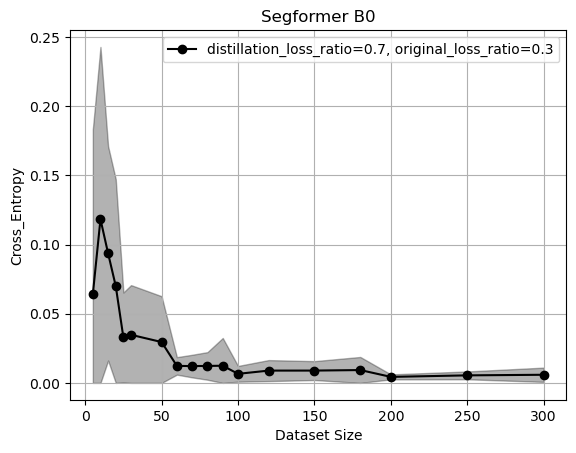

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()